### (trying to) Estimate a VAR model and compare interest rates

In [167]:
import pandas as pd
import numpy as np
from dataapi import DBConnect, SGS 
import sgs
import matplotlib.pyplot as plt
from calendars import DayCounts #Thanks to Insper Finance HUB
from tqdm import tqdm
%matplotlib inline

In [1]:
## Let's upload the data and plot some series

In [371]:
data = pd.read_excel("/Users/thaispalanca/Desktop/project macro/data_var.xlsx")
data.set_index('dat', inplace = True)
df = data[data.columns[:5]]
df.head()

,g,t,y,b,r
dat,,,,,
2002-01-01,12.186053,12.316532,15.621747,67.838157,17.044417
2002-04-01,12.195820,12.296337,15.655005,70.335742,31.066413
2002-07-01,12.190802,12.354332,15.655370,76.992823,47.903525
2002-10-01,12.143981,12.293846,15.626595,77.298321,14.134906
2003-01-01,12.013529,12.195636,15.554384,76.897200,19.399703


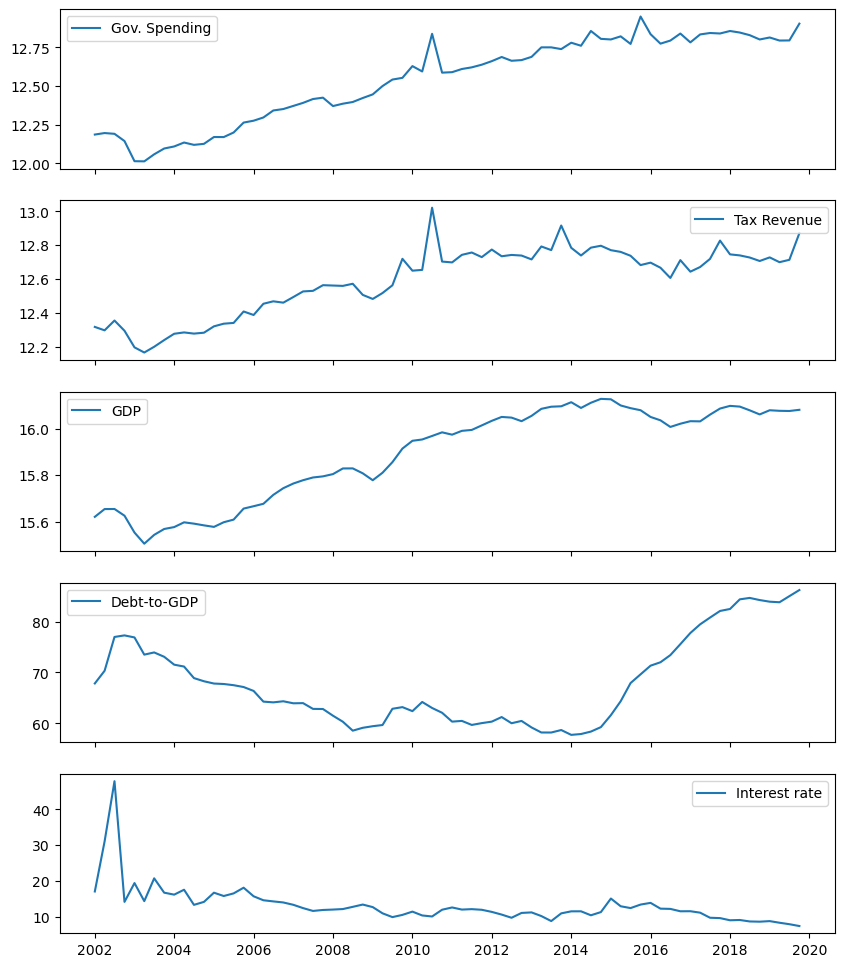

In [369]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

##subplots 

labels = ['Gov. Spending', 'Tax Revenue', 'GDP', 'Debt-to-GDP', 'Interest rate']

for i, col in enumerate(df.columns):
    axs[i].plot(df.index, df[col], label=labels[i])
    axs[i].legend() 
    
fig.savefig("./data.png")

In [276]:
##optimal lags for the model

lags = 3

#save column names
names = df.columns

model1 = df.copy()

,g,t,y,b,r
dat,,,,,
2002-01-01,12.186053,12.316532,15.621747,67.838157,17.044417
2002-04-01,12.195820,12.296337,15.655005,70.335742,31.066413
2002-07-01,12.190802,12.354332,15.655370,76.992823,47.903525
2002-10-01,12.143981,12.293846,15.626595,77.298321,14.134906
2003-01-01,12.013529,12.195636,15.554384,76.897200,19.399703


In [246]:
#get lags in the dataframe for each variable

for i in range(1, lags + 1):
    for j in names:
        df[f"{j}_Lag_{i}"] = df[j].shift(i)
        
#drop missing values
df = df.dropna()

##let's see if it worked
df.head()

,g,t,y,b,r,g_Lag_1,t_Lag_1,y_Lag_1,b_Lag_1,r_Lag_1,g_Lag_2,t_Lag_2,y_Lag_2,b_Lag_2,r_Lag_2,g_Lag_3,t_Lag_3,y_Lag_3,b_Lag_3,r_Lag_3
dat,,,,,,,,,,,,,,,,,,,,
2002-10-01,12.143981,12.293846,15.626595,77.298321,14.134906,12.190802,12.354332,15.655370,76.992823,47.903525,12.195820,12.296337,15.655005,70.335742,31.066413,12.186053,12.316532,15.621747,67.838157,17.044417
2003-01-01,12.013529,12.195636,15.554384,76.897200,19.399703,12.143981,12.293846,15.626595,77.298321,14.134906,12.190802,12.354332,15.655370,76.992823,47.903525,12.195820,12.296337,15.655005,70.335742,31.066413
2003-04-01,12.012595,12.165070,15.506647,73.511526,14.344614,12.013529,12.195636,15.554384,76.897200,19.399703,12.143981,12.293846,15.626595,77.298321,14.134906,12.190802,12.354332,15.655370,76.992823,47.903525
2003-07-01,12.058125,12.199044,15.544461,73.944718,20.724436,12.012595,12.165070,15.506647,73.511526,14.344614,12.013529,12.195636,15.554384,76.897200,19.399703,12.143981,12.293846,15.626595,77.298321,14.134906
2003-10-01,12.095697,12.238623,15.569642,73.088579,16.711416,12.058125,12.199044,15.544461,73.944718,20.724436,12.012595,12.165070,15.506647,73.511526,14.344614,12.013529,12.195636,15.554384,76.897200,19.399703


In [247]:
##save the variables in t as individual dataframes

y = df['y']
t = df['t']
g = df['g']
b = df['b']
r = df['r']

df = df.drop(['y','g', 't','y','b','r'], axis = 1)

In [48]:
df.head()

,g_Lag_1,t_Lag_1,y_Lag_1,b_Lag_1,r_Lag_1,g_Lag_2,t_Lag_2,y_Lag_2,b_Lag_2,r_Lag_2,g_Lag_3,t_Lag_3,y_Lag_3,b_Lag_3,r_Lag_3
dat,,,,,,,,,,,,,,,
2002-10-01,12.190802,12.354332,15.655370,76.992823,47.903525,12.195820,12.296337,15.655005,70.335742,31.066413,12.186053,12.316532,15.621747,67.838157,17.044417
2003-01-01,12.143981,12.293846,15.626595,77.298321,14.134906,12.190802,12.354332,15.655370,76.992823,47.903525,12.195820,12.296337,15.655005,70.335742,31.066413
2003-04-01,12.013529,12.195636,15.554384,76.897200,19.399703,12.143981,12.293846,15.626595,77.298321,14.134906,12.190802,12.354332,15.655370,76.992823,47.903525
2003-07-01,12.012595,12.165070,15.506647,73.511526,14.344614,12.013529,12.195636,15.554384,76.897200,19.399703,12.143981,12.293846,15.626595,77.298321,14.134906
2003-10-01,12.058125,12.199044,15.544461,73.944718,20.724436,12.012595,12.165070,15.506647,73.511526,14.344614,12.013529,12.195636,15.554384,76.897200,19.399703


In [248]:
###insert a column for constant
df.insert(0, 'cte', 1)

In [249]:
##transform dataframes into matrix so we can do some matrix magic
X = df.to_numpy()
y = y.to_numpy()
t = t.to_numpy()
g = g.to_numpy()
b = b.to_numpy()
r = r.to_numpy()

#### $$ \hat{\beta}=(X^T X)^{-1}(X^T y)$$

In [108]:
## let's get all the necessary parts to get beta
#transpose

In [250]:
##create a function to get beta

def beta (X, y):
    XtX = np.matmul(X.T, X)
    XtY = np.matmul(X.T, y)
    XtX_i = np.linalg.inv(XtX)
    
    return np.matmul(XtX_i, XtY)

In [251]:
beta_g = beta(X, g)
beta_t = beta(X, t)
beta_y = beta(X, y)
beta_b = beta(X, b)
beta_r = beta(X, r)

betas = np.array([beta_g, beta_t, beta_y, beta_b, beta_r])

n_variables = betas.shape[0]

In [252]:
betas = np.array([beta_g, beta_t, beta_y, beta_b, beta_r])

In [253]:
print(betas.shape)

(5, 16)


In [254]:
yhat1 = np.matmul(X, beta_y)
that1 = np.matmul(X, beta_t)
ghat1 = np.matmul(X, beta_g)
bhat1 = np.matmul(X, beta_b)
rhat1 = np.matmul(X, beta_r)

In [376]:
res_g1 = g - ghat1
res_t1 = t - that1
res_y1 = y - yhat1
res_b1 = b - bhat1
res_r1 = r - rhat1

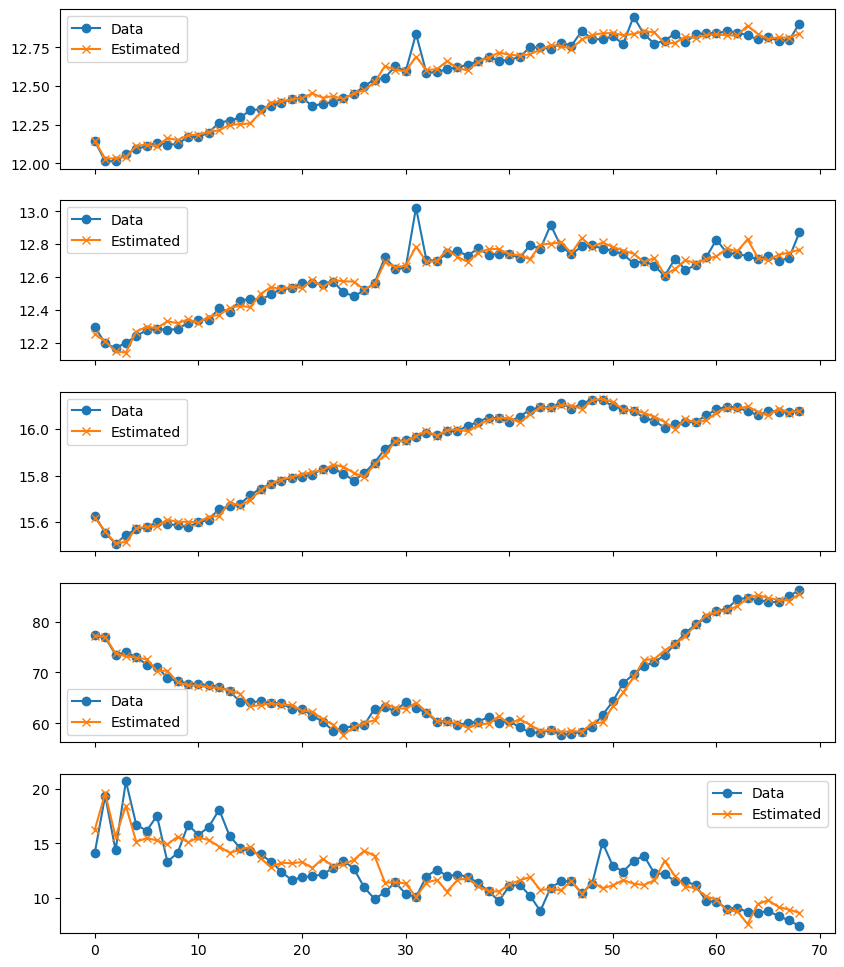

In [256]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
axs[0].plot(g, label='Data', marker='o')
axs[0].plot(ghat1, label ='Estimated', marker = 'x')
axs[0].legend()
axs[1].plot(t, label='Data', marker='o')
axs[1].plot(that1, label ='Estimated', marker = 'x')
axs[1].legend()
axs[2].plot(y, label='Data', marker='o')
axs[2].plot(yhat1, label ='Estimated', marker = 'x')
axs[2].legend()
axs[3].plot(b, label='Data', marker='o')
axs[3].plot(bhat1, label ='Estimated', marker = 'x')
axs[3].legend()
axs[4].plot(r, label='Data', marker='o')
axs[4].plot(rhat1, label ='Estimated', marker = 'x')
axs[4].legend()

fig.savefig("./realvsvar1.png")

In [279]:
###let's compare with the new series of interest rate
##optimal lags for the model

df = data.iloc[:, [0,1,2,3,5]]

lags = 3

#save column names
names = df.columns

model2 = df.copy()

In [280]:
#get lags in the dataframe for each variable

for i in range(1, lags + 1):
    for j in names:
        df[f"{j}_Lag_{i}"] = df[j].shift(i)
        
#drop missing values
df = df.dropna()

##save the variables in t as individual dataframes

y = df['y']
t = df['t']
g = df['g']
b = df['b']
ettj = df['ettj']

df = df.drop(['y','g', 't','y','b','ettj'], axis = 1)

###insert a column for constant
df.insert(0, 'cte', 1)

In [281]:
##transform dataframes into matrix so we can do some matrix magic
X = df.to_numpy()
y = y.to_numpy()
t = t.to_numpy()
g = g.to_numpy()
b = b.to_numpy()
ettj = ettj.to_numpy()

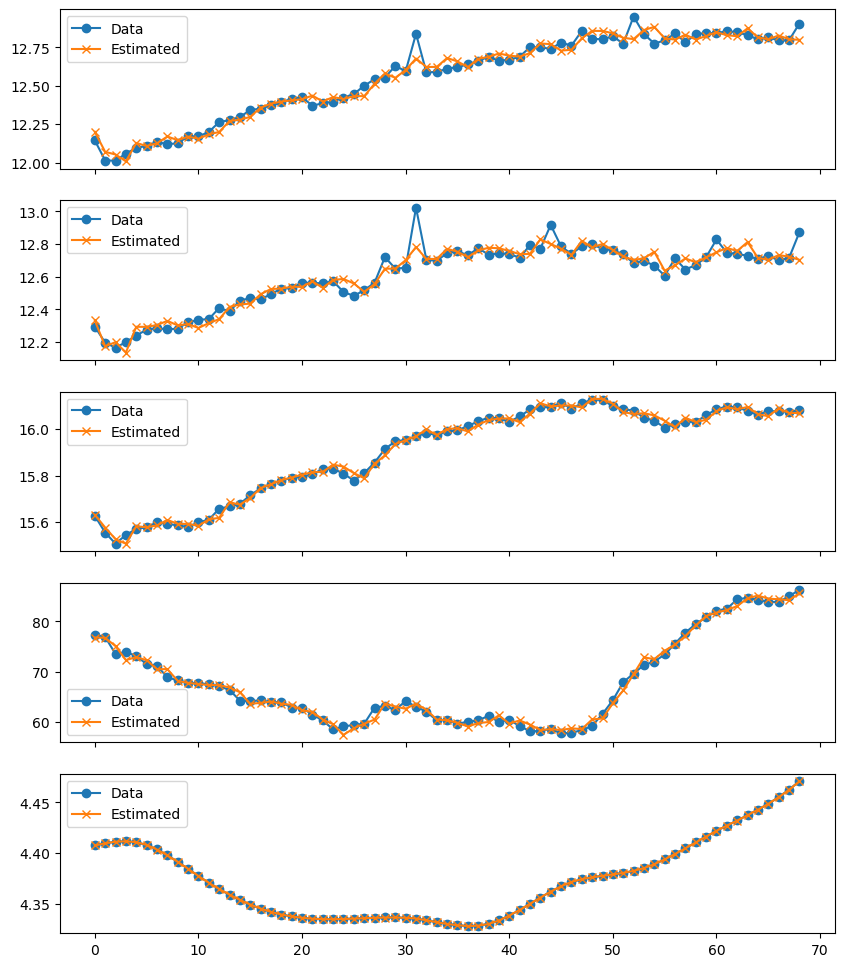

In [282]:
beta_g = beta(X, g)
beta_t = beta(X, t)
beta_y = beta(X, y)
beta_b = beta(X, b)
beta_ettj = beta(X, ettj)

yhat = np.matmul(X, beta_y)
that = np.matmul(X, beta_t)
ghat = np.matmul(X, beta_g)
bhat = np.matmul(X, beta_b)
ettjhat = np.matmul(X, beta_ettj)

ig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
axs[0].plot(g, label='Data', marker='o')
axs[0].plot(ghat, label ='Estimated', marker = 'x')
axs[0].legend()
axs[1].plot(t, label='Data', marker='o')
axs[1].plot(that, label ='Estimated', marker = 'x')
axs[1].legend()
axs[2].plot(y, label='Data', marker='o')
axs[2].plot(yhat, label ='Estimated', marker = 'x')
axs[2].legend()
axs[3].plot(b, label='Data', marker='o')
axs[3].plot(bhat, label ='Estimated', marker = 'x')
axs[3].legend()
axs[4].plot(ettj, label='Data', marker='o')
axs[4].plot(ettjhat, label ='Estimated', marker = 'x')
axs[4].legend()

ig.savefig("./datavsvar2.png")

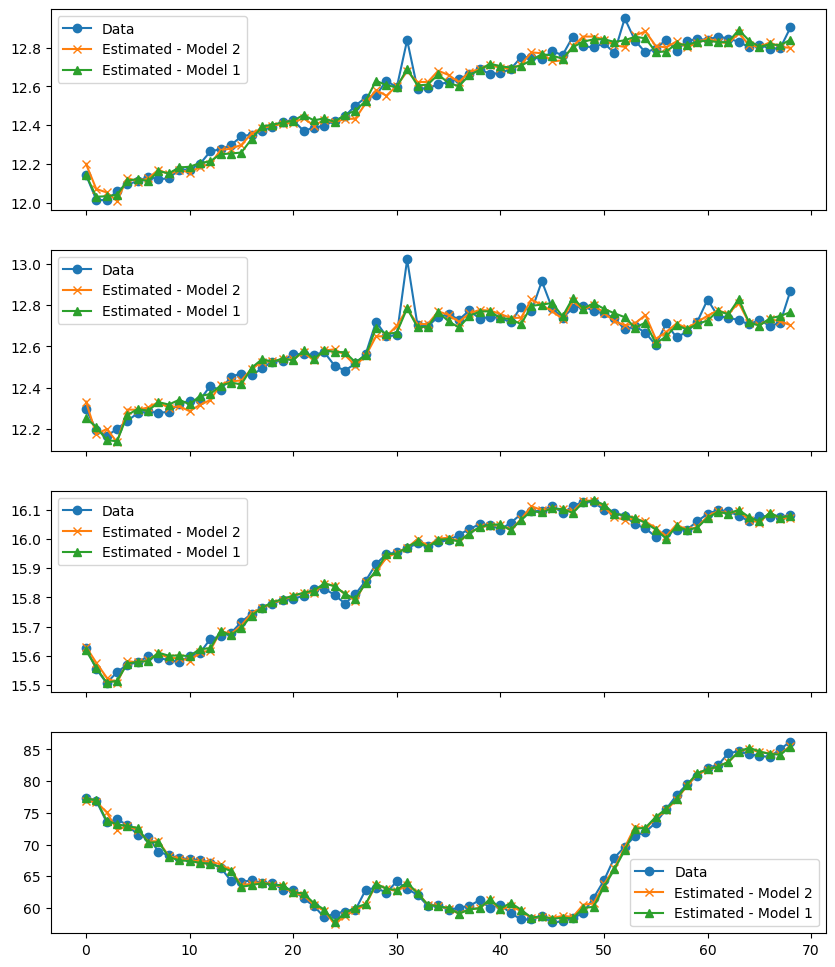

In [269]:
allfig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axs[0].plot(g, label='Data', marker='o')
axs[0].plot(ghat, label ='Estimated - Model 2', marker = 'x')
axs[0].plot(ghat1, label ='Estimated - Model 1', marker = '^')
axs[0].legend()
axs[1].plot(t, label='Data', marker='o')
axs[1].plot(that, label ='Estimated - Model 2', marker = 'x')
axs[1].plot(that1, label ='Estimated - Model 1', marker = '^')
axs[1].legend()
axs[2].plot(y, label='Data', marker='o')
axs[2].plot(yhat, label ='Estimated - Model 2', marker = 'x')
axs[2].plot(yhat1, label ='Estimated - Model 1', marker = '^')
axs[2].legend()
axs[3].plot(b, label='Data', marker='o')
axs[3].plot(bhat, label ='Estimated - Model 2', marker = 'x')
axs[3].plot(bhat1, label ='Estimated - Model 1', marker = '^')
axs[3].legend()

allfig.savefig("./datavsvarall.png")

In [390]:
res_g2 = g - ghat
res_t2 = t - that
res_y2 = y - yhat
res_b2 = b - bhat
res_ettj = ettj - ettjhat

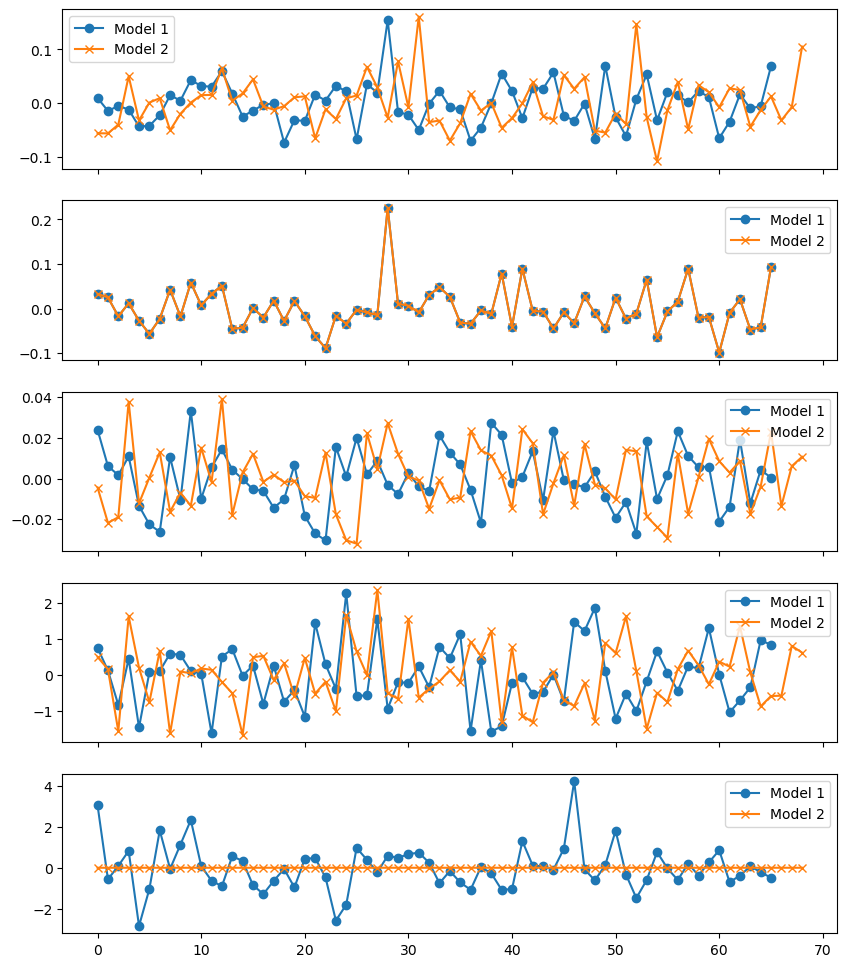

In [242]:
resfig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
axs[0].plot(res_g1, label='Model 1', marker='o')
axs[0].plot(res_g2, label ='Model 2', marker = 'x')
axs[0].legend()
axs[1].plot(res_t1, label='Model 1', marker='o')
axs[1].plot(res_t1, label ='Model 2', marker = 'x')
axs[1].legend()
axs[2].plot(res_y1, label='Model 1', marker='o')
axs[2].plot(res_y2, label ='Model 2', marker = 'x')
axs[2].legend()
axs[3].plot(res_b1, label='Model 1', marker='o')
axs[3].plot(res_b2, label ='Model 2', marker = 'x')
axs[3].legend()
axs[4].plot(res_r1, label='Model 1', marker='o')
axs[4].plot(res_ettj, label ='Model 2', marker = 'x')
axs[4].legend()

resfig.savefig("./residuals.png")

In [396]:
residuals = {}
residuals['Model 1'] = np.vstack((res_g1**2, res_t1**2, res_y1**2, res_b1**2, res_r1**2)).T
residuals['Model 2'] = np.vstack((res_g2**2, res_t2**2, res_y2**2, res_b2**2, res_ettj**2)).T

best_approx = min(residuals, key=lambda k: np.mean(residuals[k]))

lowest_residuals = np.mean(residuals[best_approx])
lowest_residuals2 = np.var(residuals[best_approx])

print(f"The best model is '{best_approx}' with an average residual of {lowest_residuals:.12f}")
print(f"The '{best_approx}' has the lowest variance of the residuals: {lowest_residuals2:.12f}")

The best model is 'Model 2' with an average residual of 0.146655300394
The 'Model 2' has the lowest variance of the residuals: 0.291712014704


In [266]:
df = pd.DataFrame({
    'Spending residuals': resg,
    'Tax revenue residuals': rest,
    'Output residuals': resy,
    'Debt-to-GDP residuals': resb,
    'Interest rate residuals': resr
})

# Alternativamente, se preferir LaTeX
df.to_latex('residualscomp.tex', index=False)

df

,Spending residuals,Tax revenue residuals,Output residuals,Debt-to-GDP residuals,Interest rate residuals
0,-0.055330,0.003899,0.003532,-0.458989,2.137134
1,-0.039517,-0.010344,-0.016584,-0.071217,0.202263
2,-0.019969,-0.014355,-0.017544,-1.298861,1.252332
3,-0.032082,-0.003491,-0.007817,-0.868439,2.273959
4,-0.015172,-0.026118,-0.008938,-0.021556,1.567213
5,0.011539,0.003391,0.001471,0.323632,0.692382
6,0.014598,-0.016855,0.003884,0.203604,2.256905
7,-0.007025,0.000267,0.001710,-0.156672,1.598832
8,0.005035,0.015960,0.008046,0.134614,1.483494
9,0.009851,0.010777,0.008999,0.282283,1.605941


In [229]:
df = pd.DataFrame({
    'Spending residuals (model 1)': resg1[:10],
     'Spending residuals (model 2)': res_g2[:10], 
    'Tax revenue residuals (model 1)': res_t1[:10],
    'Tax revenue residuals (model 2)': res_t2[:10],
    'Output residuals (model 1)': res_y1[:10],
    'Output residuals (model 2)': res_y2[:10],
    'Debt-to-GDP residuals (model 1)': res_b1[:10],
     'Debt-to-GDP residuals (model 2)': res_b2[:10],
    'Interest rate residuals (model 1)': res_r1[:10],
    '(Interpolated)Interest rate residuals (model 2)': res_ettj[:10] 
})

# Alternativamente, se preferir LaTeX
df.to_latex('residuals.tex', index=False)

In [74]:
#covariance of residuals

cov_res = np.cov(res_matrix, rowvar=False)

In [346]:
##identification matrix

# Create A matrix
A = np.array([[1, 0, 0, 0, 0], [0, 1, -2.0322, 0, 0], ['e', 'e', 1, 0, 0], ['e', 'e', 'e', 1, 'e'], ['e', 'e', 'e', 'e', 1]])
print(A)


[['1' '0' '0' '0' '0']
 ['0' '1' '-2.0322' '0' '0']
 ['e' 'e' '1' '0' '0']
 ['e' 'e' 'e' '1' 'e']
 ['e' 'e' 'e' 'e' '1']]


In [414]:
# Create a matrix with e values
B1 = np.array([[1, 0, 0, 0, 0],
              ['e', 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1]])


In [327]:
import statsmodels.api as sm
model1.head()

,g,t,y,b,r
dat,,,,,
2002-01-01,12.186053,12.316532,15.621747,67.838157,17.044417
2002-04-01,12.195820,12.296337,15.655005,70.335742,31.066413
2002-07-01,12.190802,12.354332,15.655370,76.992823,47.903525
2002-10-01,12.143981,12.293846,15.626595,77.298321,14.134906
2003-01-01,12.013529,12.195636,15.554384,76.897200,19.399703


/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


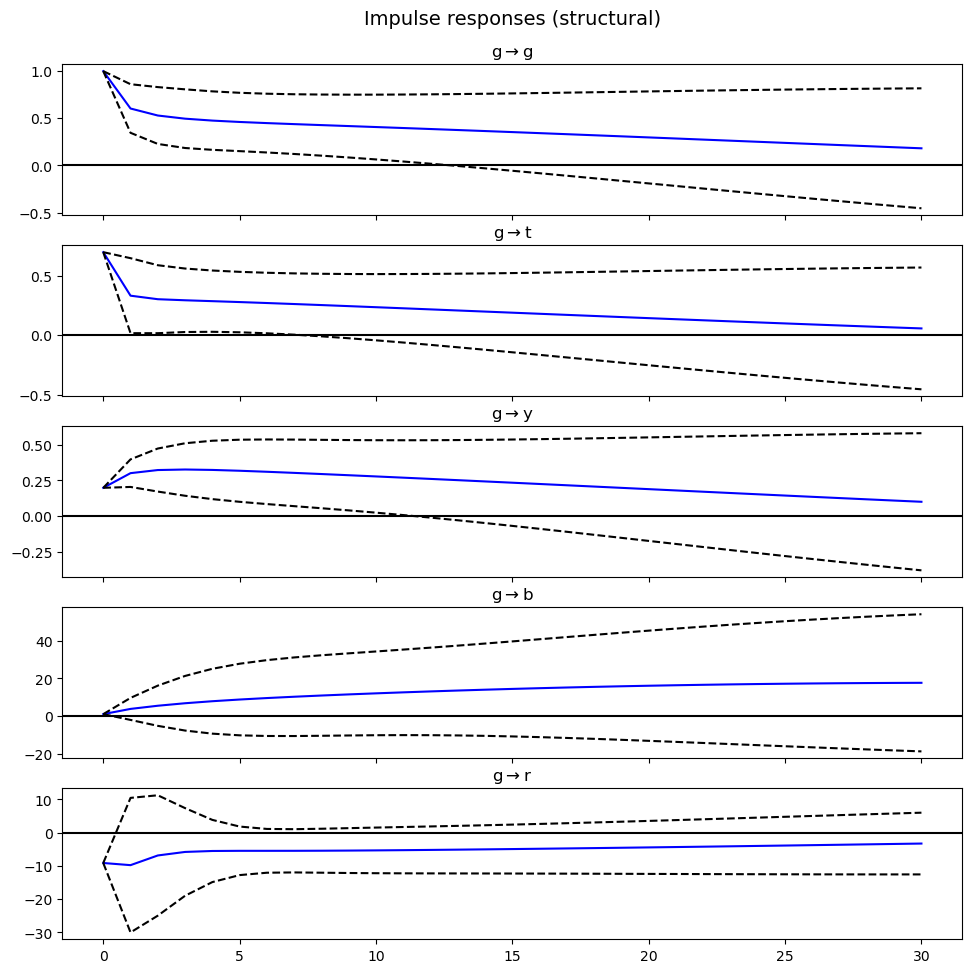

In [475]:
# I tried to proceed with the SVAR, however there's still a lot to adjust here
model = sm.tsa.SVAR(model1, svar_type='AB', A=A, B =B1)

result = model.fit()

#IRFs
irf_g = result.irf(periods=30)  # 10 períodos de resposta ao impulso
irf_g.plot(impulse = 0, orth=False)  # Plota as IRFs
plt.savefig('irf_g1.png')
plt.show()

In [ ]:
# Create a matrix with e values
B = np.array([[1, 'e', 0, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1]])

/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


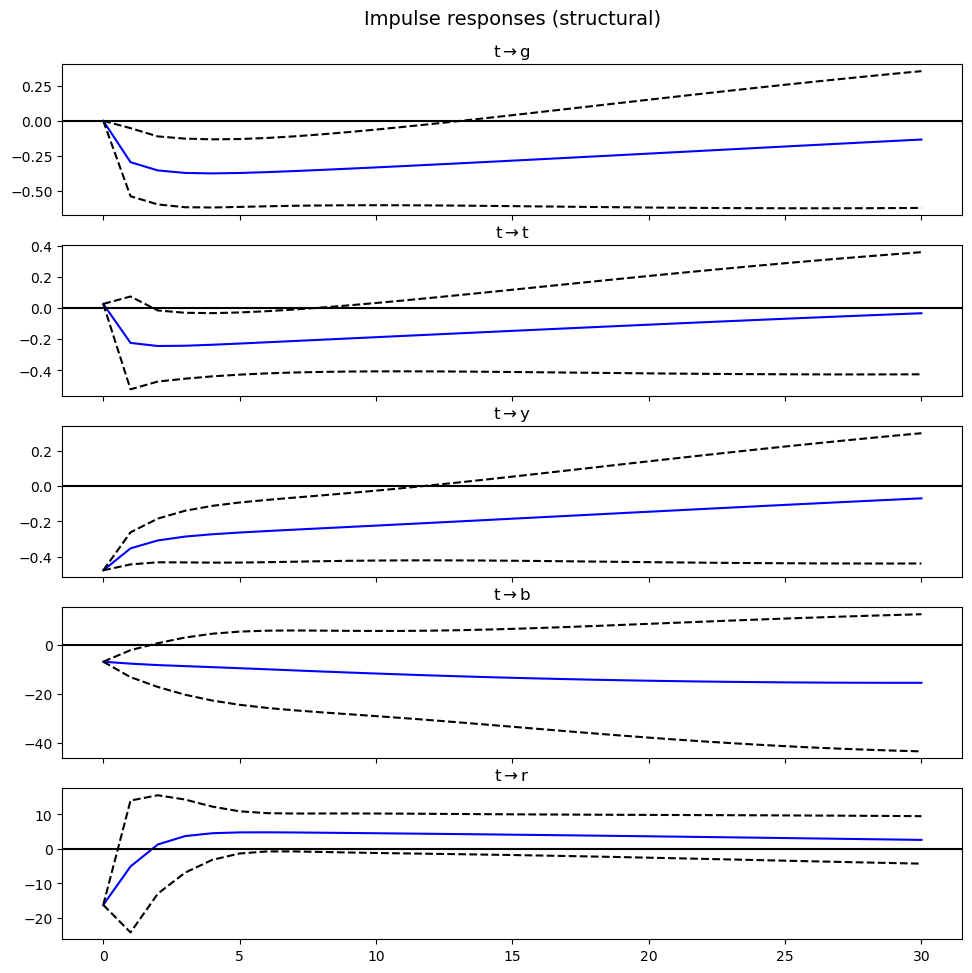

In [483]:
# shock in t
model = sm.tsa.SVAR(model1, svar_type='AB', A=A, B =B)

result = model.fit()

#IRFs
irf = result.irf(periods=30) 
irf.plot(impulse = 1, orth=False) 
plt.savefig('irf_t1.png')
plt.show()

/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


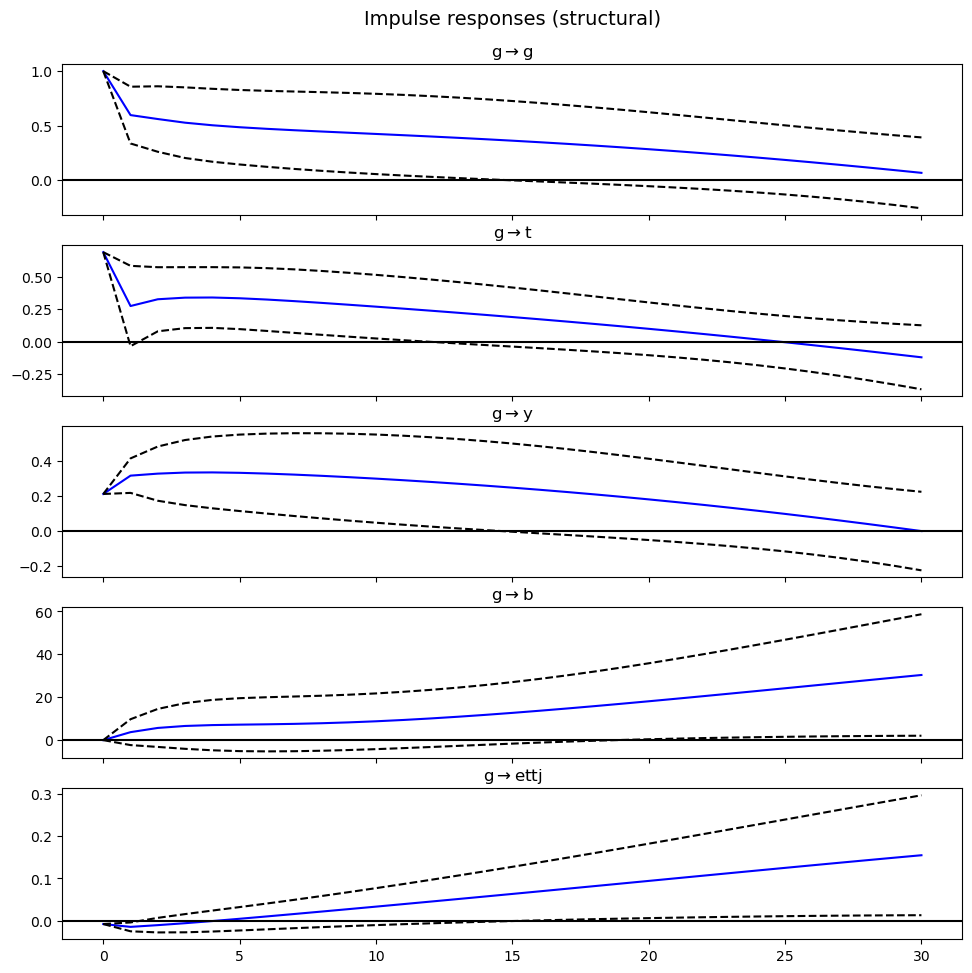

In [484]:
#SVAR model
model = sm.tsa.SVAR(model2, svar_type='AB', A=A, B =B1)

result = model.fit()

irf = result.irf(periods=30)  
irf.plot(impulse = 0, orth=False)  
plt.savefig('irf_g2.png')
plt.show()

/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/thaispalanca/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


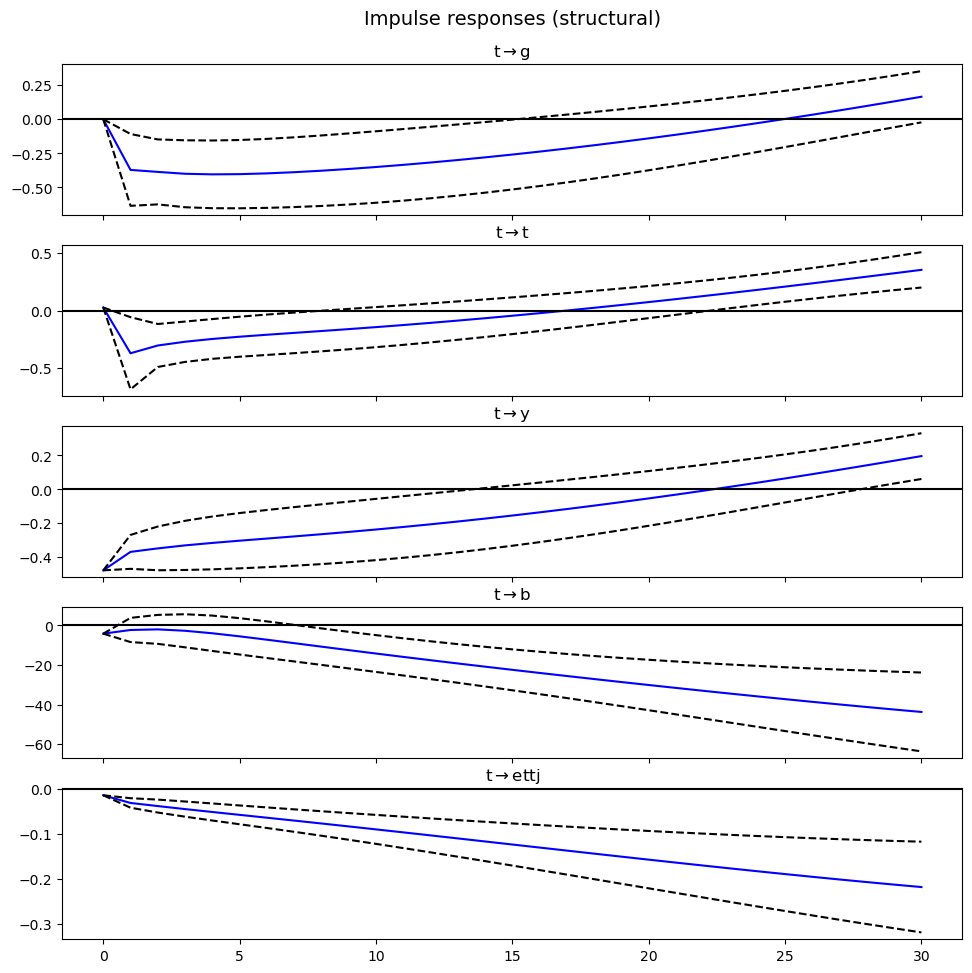

In [485]:
#SVAR model
model = sm.tsa.SVAR(model2, svar_type='AB', A=A, B =B)

result = model.fit()

irf = result.irf(periods=30)  
irf.plot(impulse = 1, orth=False) 
plt.savefig('irf_t2.png')
plt.show()